In [1]:
import pickle
import preprocessing
import pandas as pd
import nltk
import re
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import string

def stripLineBreak(x):
    return x.replace('\n', '')

def createConversations(all_text):
    conv = [[all_text[idx_text], all_text[idx_text+1]] for idx_text, text in enumerate(all_text[:-1])]
    return conv

In [2]:
#dataset = 'enron'
#df_enron = pd.read_csv('../enron/Enron_Email_Threads_Clean_v2.csv')

#df_enron_convs = df_enron.groupby('Subject')['CleanBody'].agg({'count', 'unique'}).reset_index()

#df_enron_convs = df_enron_convs[df_enron_convs['count']>1]

#conv_text = df_enron_convs['unique'].values

#text_conversations = [pd.DataFrame(createConversations(all_text), columns=['Pair_0', 'Pair_1']) for all_text in conv_text]

In [3]:
#dataset = 'de_en'
#t_enc = open(r'C:\Users\euix\nmt_data\wmt16_de_en\train.en', 'r', encoding='utf8')
#t_dec = open(r'C:\Users\euix\nmt_data\wmt16_de_en\train.de', 'r', encoding='utf8')

#t_enc = t_enc.readlines()
#t_dec = t_dec.readlines()

In [4]:
dataset = 'twitter'

In [5]:
twitter_data = open('../../datasets/chat.txt', 'r', encoding='utf-8')

twitter_lines = twitter_data.readlines()

twitter_convs = [[line for idx, line in enumerate(twitter_lines) if idx%2==1], 
              [line for idx, line in enumerate(twitter_lines) if idx%2==0]]

df_all = pd.DataFrame(list(zip(*twitter_convs)), columns=['Pair_0', 'Pair_1']) 

In [ ]:
twitter_data = open('../../datasets/chat_corpus/cleaned_corpus_en.txt', 'r', encoding='utf-8')

twitter_lines = twitter_data.readlines()

twitter_convs = [[line for idx, line in enumerate(twitter_lines) if idx%2==1], 
              [line for idx, line in enumerate(twitter_lines) if idx%2==0]]

df_all = pd.DataFrame(list(zip(*twitter_convs)), columns=['Pair_0', 'Pair_1']) 

In [7]:
df_all.shape

(2601244, 2)

In [15]:
#Grab questions only
df_all = df_all[(df_all['Pair_0'].str.contains('\?'))]

In [18]:
#df_all = pd.DataFrame(list(zip(t_enc, t_dec)), columns=['Pair_0', 'Pair_1'])
#df_all = pd.concat(text_conversations)

In [19]:
#df_all = df_all.sample(frac=1, random_state=0)

In [20]:
df_all['Pair_0'] = df_all['Pair_0'].apply(preprocessing.remove_non_ascii)

df_all['Pair_1'] = df_all['Pair_1'].apply(preprocessing.remove_non_ascii)

c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
df_all['Pair_0'] = df_all['Pair_0'].apply(stripLineBreak)

df_all['Pair_1'] = df_all['Pair_1'].apply(stripLineBreak)

c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
Pair_0_char_checked = Parallel(n_jobs=-1, verbose=8)(delayed(preprocessing.checkChars)(i) for i in df_all['Pair_0'].values)
Pair_1_char_checked = Parallel(n_jobs=-1, verbose=8)(delayed(preprocessing.checkChars)(i) for i in df_all['Pair_1'].values)

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 55541 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 255853 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 333769 out of 333769 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 53356 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 230148 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 333769 out of 333769 | elapsed:   13.2s finished


In [23]:
df_all.shape, len(Pair_0_char_checked)

((333769, 2), 333769)

In [24]:
df_all['Pair_0_char_checked'] = Pair_0_char_checked

df_all['Pair_1_char_checked'] = Pair_1_char_checked

c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
Pair_0_char_checked = []
Pair_1_char_checked = []

In [26]:
alpha_Pair_0_tokens = Parallel(n_jobs=-1, verbose=8)(\
                            delayed(preprocessing.checkAlphaLower)(i) for i in df_all['Pair_0_char_checked'].values)

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 11351 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 37909 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 69887 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 106201 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 147935 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 194005 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 245495 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 301321 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 333769 out of 333769 | elapsed:   43.9s finished


In [27]:
alpha_Pair_1_tokens = Parallel(n_jobs=-1, verbose=8)(\
                            delayed(preprocessing.checkAlphaLower)(i) for i in df_all['Pair_1_char_checked'].values)

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 10996 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 40788 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 76660 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 117396 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 164212 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 215892 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 273652 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 333769 out of 333769 | elapsed:   39.7s finished


In [28]:
df_all['alpha_Pair_0_tokens'] = list(zip(*alpha_Pair_0_tokens))[0]

df_all['alpha_Pair_1_tokens'] = list(zip(*alpha_Pair_1_tokens))[0]

c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
df_all['n_alpha_Pair_0_tokens'] = list(zip(*alpha_Pair_0_tokens))[1]

df_all['n_alpha_Pair_1_tokens'] = list(zip(*alpha_Pair_1_tokens))[1]

c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\euix\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
df_all.head().values[4]

array([ "if you are attacked maliciously, don't you want to defend yourself? if not, you're crazy.",
       'donald trump shames ex-miss universe for her sexual past in late-night twitter barrage:',
       'if you are attacked maliciously  don t you want to defend yourself? if not  you re crazy.',
       'donald trump shames ex miss universe for her sexual past in late night twitter barrage ',
       list(['if', 'you', 'are', 'attacked', 'maliciously', 'don', 't', 'you', 'want', 'to', 'defend', 'yourself', '?', 'if', 'not', 'you', 're', 'crazy', '<EOS>']),
       list(['donald', 'trump', 'shames', 'ex', 'miss', 'universe', 'for', 'her', 'sexual', 'past', 'in', 'late', 'night', 'twitter', 'barrage', '<EOS>']),
       19, 16], dtype=object)

In [31]:
alpha_quote_tokens = []
alpha_mcp_tokens = []

In [32]:
df_all = df_all[df_all['n_alpha_Pair_0_tokens'] != 0]

df_all = df_all[df_all['n_alpha_Pair_1_tokens'] != 0]

In [33]:
alpha_stem_Pair_0_tokens = Parallel(n_jobs=-1, verbose=8)(\
                            delayed(preprocessing.nltkStem)(i) for i in df_all['alpha_Pair_0_tokens'].values)

df_all['alpha_stem_Pair_0_tokens'] = list(zip(*alpha_stem_Pair_0_tokens))[0]
df_all['n_alpha_stem_Pair_0_tokens'] = list(zip(*alpha_stem_Pair_0_tokens))[1]

alpha_stem_Pair_1_tokens = Parallel(n_jobs=-1, verbose=8)(\
                            delayed(preprocessing.nltkStem)(i) for i in df_all['alpha_Pair_1_tokens'].values)

df_all['alpha_stem_Pair_1_tokens'] = list(zip(*alpha_stem_Pair_1_tokens))[0]

df_all['n_alpha_stem_Pair_1_tokens'] = list(zip(*alpha_stem_Pair_1_tokens))[1]

alpha_stem_quote_tokens = []
alpha_stem_quote_tokens = []

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 15085 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 63399 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 121573 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 187635 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 263557 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 333769 out of 333769 | elapsed:   29.5s finished
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 12637 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 50955 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 97093 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 149487 t

In [34]:
alpha_lem_Pair_0_tokens = Parallel(n_jobs=-1, verbose=8)(\
                            delayed(preprocessing.nltkLem)(i) for i in df_all['alpha_Pair_0_tokens'].values)

df_all['alpha_lem_Pair_0_tokens'] = list(zip(*alpha_lem_Pair_0_tokens))[0]
df_all['n_alpha_lem_Pair_0_tokens'] = list(zip(*alpha_lem_Pair_0_tokens))[1]

alpha_lem_Pair_1_tokens = Parallel(n_jobs=-1, verbose=8)(\
                            delayed(preprocessing.nltkLem)(i) for i in df_all['alpha_Pair_1_tokens'].values)

df_all['alpha_lem_Pair_1_tokens'] = list(zip(*alpha_lem_Pair_1_tokens))[0]

df_all['n_alpha_lem_Pair_1_tokens'] = list(zip(*alpha_lem_Pair_1_tokens))[1]

alpha_lem_quote_tokens = []
alpha_lem_quote_tokens = []

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 58148 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 182373 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 333769 out of 333769 | elapsed:   17.6s finished
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 57728 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 176769 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 333769 out of 333769 | elapsed:   18.1s finished


In [35]:
df_all.to_pickle(
                '../../datasets/%s_preprocess_pickle_stage_0_sample_%d_questions_only.pkl' % (dataset, df_all.shape[0]))

In [35]:
df_all[:int(df_all.shape[0]/2)].to_pickle(
                '../../datasets/%s_preprocess_pickle_stage_0_sample_%d_part_1.pkl' % (dataset, df_all.shape[0]))

In [36]:
df_all[int(df_all.shape[0]/2):].to_pickle(
                '../../datasets/%s_preprocess_pickle_stage_0_sample_%d_part_2.pkl' % (dataset, df_all.shape[0]))

In [5]:
df_all = pd.read_pickle('../../datasets/twitter_preprocess_pickle_stage_0_sample_333769_questions_only.pkl')

df_all_1 = pd.read_pickle('../../datasets/twitter_preprocess_pickle_stage_0_sample_2601244_part_1.pkl')

df_all_2 = pd.read_pickle('../../datasets/twitter_preprocess_pickle_stage_0_sample_2601244_part_2.pkl')

df_all = pd.concat([df_all_1, df_all_2])

df_all_1 = []
df_all_2 = []

In [6]:
#df_all = df_all.sample(frac=0.1)

In [7]:
df_all.shape

(2601244, 16)

In [51]:
flat_list_pair_0 = [item for sublist in df_all['alpha_lem_Pair_0_tokens'].values for item in sublist]

flat_list_pair_1 = [item for sublist in df_all['alpha_lem_Pair_1_tokens'].values for item in sublist]

flat_list = flat_list_pair_0 + flat_list_pair_1

fdist_quote = FreqDist(flat_list)

words = fdist_quote.keys()

word_counts = fdist_quote.values()

df_all_word_counts = pd.DataFrame(list(zip(words, word_counts)), columns=['word', 'word_counts'])

In [52]:
df_all_word_counts.sort_values(by=['word_counts'], ascending=True, inplace=True)

In [53]:
df_all_word_counts.groupby('word_counts').count().head()

,word
word_counts,
1,15
2,21
3,28
4,40
5,82


(array([  3.86600000e+04,   4.60000000e+01,   1.30000000e+01,
          1.10000000e+01,   2.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   4.00000000e+00,   3.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

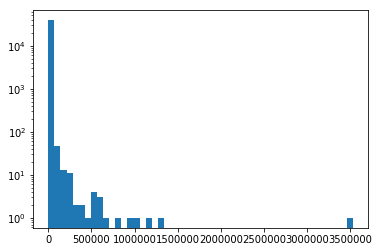

In [54]:
plt.hist(df_all_word_counts['word_counts'].values, bins=50, log=True)

In [54]:
#df_all_word_counts.to_pickle('%s_word_occurrence_sample_%d_lem_questions.pkl' % (dataset,  df_all.shape[0]))

In [55]:
#sent_lengths = sum([list(df_all['n_alpha_lem_Pair_0_tokens'].values), list(df_all['n_alpha_lem_Pair_1_tokens'].values)], [])

In [56]:
#plt.hist(sent_lengths, log=True, bins=[i for i in range(70)])

In [57]:
#mcp_rare_words = Parallel(n_jobs=-1, verbose=8)(delayed(preprocessing.countWordOccurence)(i) \
#                                                for i in df_all['alpha_Pair_0_tokens'].values)

#df_all['Pair_0_rare_words'] = mcp_rare_words

In [58]:
#mcp_rare_words = []

In [8]:
check_word_pair_0 = 'alpha_lem_Pair_0_tokens'
check_word_pair_1 = 'alpha_lem_Pair_1_tokens'

In [9]:
processing_type='lem'

In [10]:
for i in range(0, 20, 1):
    #func = lambda x: preprocessing.checkWordOccurrence(x, i)
    func_length = lambda x: preprocessing.checkWordOccurrenceLength(x, i)

    #df_all['alpha_%s_Pair_0_tokens_%d_word' % (processing_type, i+1)] = df_all['alpha_%s_Pair_0_tokens' % processing_type].apply(func)
        
    #df_all['alpha_%s_Pair_1_tokens_%d_word' % (processing_type, i+1)] = df_all['alpha_%s_Pair_1_tokens' % processing_type].apply(func)

    df_all['n_alpha_%s_Pair_0_tokens_%d_word' % (processing_type, i+1)] = \
                df_all['alpha_%s_Pair_0_tokens' % processing_type].apply(func_length)

    df_all['n_alpha_%s_Pair_1_tokens_%d_word' % (processing_type, i+1)] = \
               df_all['alpha_%s_Pair_1_tokens' % processing_type].apply(func_length)


In [14]:
df_all = df_all[(df_all['n_alpha_lem_Pair_0_tokens']>2) & (df_all['n_alpha_lem_Pair_1_tokens']>2)]

In [15]:
df_all = df_all[(df_all['n_alpha_lem_Pair_0_tokens']<26) & (df_all['n_alpha_lem_Pair_1_tokens']<26)]

In [16]:
df_all.shape

(2292441, 56)

In [34]:
df_all = df_all[
		(df_all['n_alpha_lem_Pair_0_tokens_1_word']==0) &
		(df_all['n_alpha_lem_Pair_1_tokens_1_word']==0) &
		(df_all['n_alpha_lem_Pair_0_tokens_2_word']==0) &
		(df_all['n_alpha_lem_Pair_1_tokens_2_word']==0) &
		(df_all['n_alpha_lem_Pair_0_tokens_3_word']==0) &
		(df_all['n_alpha_lem_Pair_1_tokens_3_word']==0) &
		(df_all['n_alpha_lem_Pair_0_tokens_4_word']==0) &
		(df_all['n_alpha_lem_Pair_1_tokens_4_word']==0) &
		(df_all['n_alpha_lem_Pair_0_tokens_5_word']==0) &
		(df_all['n_alpha_lem_Pair_1_tokens_5_word']==0)  &
		(df_all['n_alpha_lem_Pair_0_tokens_6_word']==0) &
		(df_all['n_alpha_lem_Pair_1_tokens_6_word']==0)  &
		(df_all['n_alpha_lem_Pair_0_tokens_7_word']==0) &
		(df_all['n_alpha_lem_Pair_1_tokens_7_word']==0)  &
    	(df_all['n_alpha_lem_Pair_0_tokens_8_word']==0) &
		(df_all['n_alpha_lem_Pair_1_tokens_8_word']==0)  &
    	(df_all['n_alpha_lem_Pair_0_tokens_9_word']==0) &
		(df_all['n_alpha_lem_Pair_1_tokens_9_word']==0) & 
    	(df_all['n_alpha_lem_Pair_0_tokens_10_word']==0) &
		(df_all['n_alpha_lem_Pair_1_tokens_10_word']==0)  &
    	(df_all['n_alpha_lem_Pair_0_tokens_11_word']==0) &
		(df_all['n_alpha_lem_Pair_1_tokens_11_word']==0) &
		(df_all['n_alpha_lem_Pair_0_tokens_12_word']==0) &
		(df_all['n_alpha_lem_Pair_1_tokens_12_word']==0) &
		(df_all['n_alpha_lem_Pair_0_tokens_13_word']==0) &
		(df_all['n_alpha_lem_Pair_1_tokens_13_word']==0) &
		(df_all['n_alpha_lem_Pair_0_tokens_14_word']==0) &
		(df_all['n_alpha_lem_Pair_1_tokens_14_word']==0) &
		(df_all['n_alpha_lem_Pair_0_tokens_15_word']==0) &
		(df_all['n_alpha_lem_Pair_1_tokens_15_word']==0)  &
		(df_all['n_alpha_lem_Pair_0_tokens_16_word']==0) &
		(df_all['n_alpha_lem_Pair_1_tokens_16_word']==0)  &
		(df_all['n_alpha_lem_Pair_0_tokens_17_word']==0) &
		(df_all['n_alpha_lem_Pair_1_tokens_17_word']==0)  &
    	(df_all['n_alpha_lem_Pair_0_tokens_18_word']==0) &
		(df_all['n_alpha_lem_Pair_1_tokens_18_word']==0)  &
    	(df_all['n_alpha_lem_Pair_0_tokens_19_word']==0) &
		(df_all['n_alpha_lem_Pair_1_tokens_19_word']==0) & 
    	(df_all['n_alpha_lem_Pair_0_tokens_20_word']==0) &
		(df_all['n_alpha_lem_Pair_1_tokens_20_word']==0)  
                   ] 

In [35]:
#plt.hist(df_all[df_all['Pair_0_rel_rare_word_count']>=0]['Pair_0_rel_rare_word_count'].values, log=True, bins=50)

In [36]:
#df_all[df_all['Pair_0_rel_rare_word_count']<0.0001].shape[0], df_all.shape[0]

In [37]:
#float(df_all[df_all['Pair_0_rel_rare_word_count']<0.001].shape[0])/df_all.shape[0]

In [38]:
#df_all_no_rare = df_all

In [39]:
seq_min = min(df_all['n_alpha_lem_Pair_0_tokens'].min(), df_all['n_alpha_lem_Pair_1_tokens'].min())
seq_max = min(df_all['n_alpha_lem_Pair_0_tokens'].max(), df_all['n_alpha_lem_Pair_1_tokens'].max())

print (seq_min, seq_max)

3 25


In [40]:
#word_counts = df_all_word_counts['word_counts'].values

In [41]:
#plt.hist(word_counts, log=True, bins=50)

In [42]:
Pair_0_words = set.union(*[set(i) for i in df_all['alpha_lem_Pair_0_tokens'].values])

Pair_1_words = set.union(*[set(i) for i in df_all['alpha_lem_Pair_1_tokens'].values])

vocab_set = list(Pair_0_words.union(Pair_1_words))

In [43]:
len(vocab_set), df_all.shape

(38749, (1764604, 56))

In [44]:
vocab_dict = Parallel(n_jobs=-1, verbose=8)(\
                    delayed(preprocessing.createDict)(word, word_idx) for word_idx, word in enumerate(vocab_set))

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 10822 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 38749 out of 38749 | elapsed:   17.3s finished


In [45]:
vocab_dict = { k: v for d in vocab_dict for k, v in d.items()}

In [46]:
vocab_dict['<PAD>'] = 0
vocab_dict['<EOS>'] = 1
vocab_dict['<UNK>'] = 2

In [47]:
def encodeSent(sent):

    if type(sent) == str: sent = sent.split(' ')
    
    return [vocab_dict[word] if word in vocab_dict else 2 for word in sent]

In [48]:
df_final = pd.DataFrame()

In [49]:
df_final['alpha_Pair_1_encoding'] =  df_all['alpha_lem_Pair_0_tokens'].apply(encodeSent)
df_final['alpha_Pair_0_encoding'] = df_all['alpha_lem_Pair_1_tokens'].apply(encodeSent)

df_final['Index'] = df_all.index.values

In [50]:
df_final.to_pickle(\
    '../processed_data/processed_data_v02_%s_py35_seq_length_%d_%d_sample_%d_questions.pkl' % (dataset, seq_min, seq_max, df_all.shape[0]))

pickle.dump(vocab_dict, \
    open('../processed_data/word_dict_v02_%s_py35_seq_length_%d_%d_sample_%d_questions.pkl' % (dataset, seq_min, seq_max, df_all.shape[0]) , 'wb'))